# Localization with RBallLike

`rball` provides a 3ML plugin that can perform localization of point sources.



First we need to read in the database.

In [1]:
from astromodels import Powerlaw, PointSource, Model, Log_uniform_prior, Uniform_prior
from threeML import BayesianAnalysis, DataList


from rball import ResponseDatabase, RBallLike
from rball.utils import get_path_of_data_file
import h5py

%matplotlib inline

[WARNING ] The naima package is not available. Models that depend on it will not be available


[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.


[WARNING ] The ebltable package is not available. Models that depend on it will not be available


[INFO    ] Starting 3ML!


[WARNING ] no display variable set. using backend for graphics without display (agg)


[INFO    ] Starting 3ML!


[WARNING ] no display variable set. using backend for graphics without display (agg)


[WARNING ] ROOT minimizer not available


[WARNING ] Multinest minimizer not available


[WARNING ] PyGMO is not available


[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)


[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?


[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?


[WARNING ] No fermitools installed


[WARNING ] Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


[WARNING ] Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


[WARNING ] Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


In [2]:
file_name = get_path_of_data_file("demo_rsp_database.h5")

with h5py.File(file_name, "r") as f:

    # the base grid point matrices
    # should be an (N grid points, N ebounds, N monte carlo energies)
    # numpy array

    list_of_matrices = f["matrix"][()]

    # theta and phi are the
    # lon and lat points of
    # the matrix database in radian

    theta = f["theta"][()]

    phi = f["phi"][()]

    # the bounds of the response

    ebounds = f["ebounds"][()]

    mc_energies = f["mc_energies"][()]

    rsp_db = ResponseDatabase(
        list_of_matrices=list_of_matrices,
        theta=theta,
        phi=phi,
        ebounds=ebounds,
        monte_carlo_energies=mc_energies,
    )

We can create an RBallLike from normal PHA files. We will use a simulated spectrum that comes from a position on the sky (RA: 150 Dec: 0) with a power law spectrum.

In [3]:
demo_plugin = RBallLike.from_ogip(
    "demo",
    observation=get_path_of_data_file("demo.pha"),
    spectrum_number=1,
    response_database=rsp_db,
)

[INFO    ] Auto-probed noise models:


[INFO    ] - observation: poisson


[INFO    ] - background: None


[INFO    ] Auto-probed noise models:


[INFO    ] - observation: poisson


[INFO    ] - background: None


## Fitting for the localization

We will create a 3ML point source and assign priors to the spectral parameters. The ```RBallLike``` plugin automatically assigns uniform spherical priors to the sky position. This can always be altered in the model



In [4]:
source_function = Powerlaw(K=1, index=-2, piv=100)

source_function.K.prior = Log_uniform_prior(lower_bound=1e-1, upper_bound=1e1)
source_function.index.prior = Uniform_prior(lower_bound=-4, upper_bound=0)

ps = PointSource("ps", 150.0, 1.0, spectral_shape=source_function)

model = Model(ps)

In [5]:
ba = BayesianAnalysis(model, DataList(demo_plugin))

[INFO    ] freeing the position of demo and setting priors


In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (4):
--------------------

                                 value min_value max_value            unit
ps.position.ra                   150.0       0.0     360.0             deg
ps.position.dec                    1.0     -90.0      90.0             deg
ps.spectrum.main.Powerlaw.K        1.0       0.0    1000.0  keV-1 s-1 cm-2
ps.spectrum.main.Powerlaw.index   -2.0     -10.0      10.0                

Fixed parameters (2):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Now we can sample the spectrum and position to do the localization.

In [7]:
ba.set_sampler("emcee")
ba.sampler.setup(n_walkers=50, n_iterations=1000.0, n_burnin=1000)

[INFO    ] sampler set to emcee


In [8]:
ba.sample()

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[INFO    ] Mean acceptance fraction: 0.48012


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
ps.position.ra,(1.47 -0.15 +0.14) x 10^2,deg
ps.position.dec,2 +/- 6,deg
ps.spectrum.main.Powerlaw.K,1.07 -0.06 +0.05,1 / (cm2 keV s)
ps.spectrum.main.Powerlaw.index,-1.993 -0.029 +0.030,



Values of -log(posterior) at the minimum:



,-log(posterior)
demo,-407.645953
total,-407.645953



Values of statistical measures:



,statistical measures
AIC,823.617110
BIC,834.700028
DIC,819.252436
PDIC,-0.620218



WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()



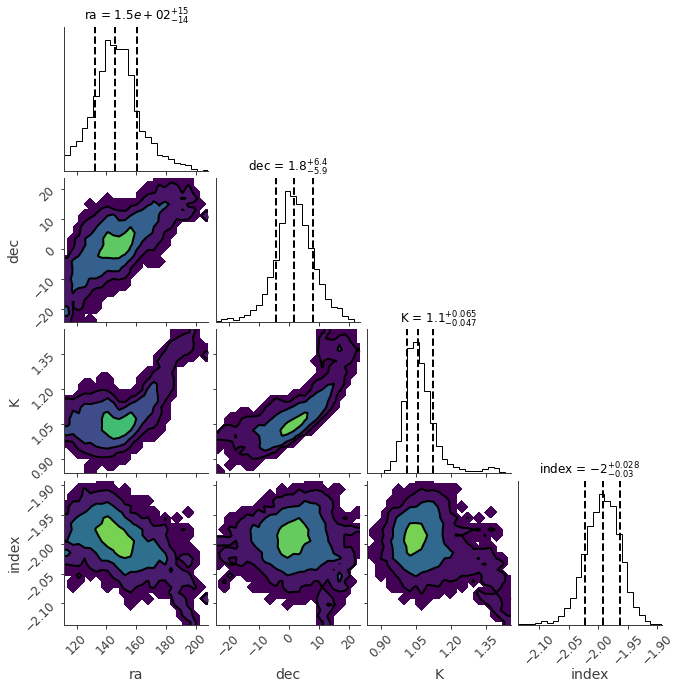

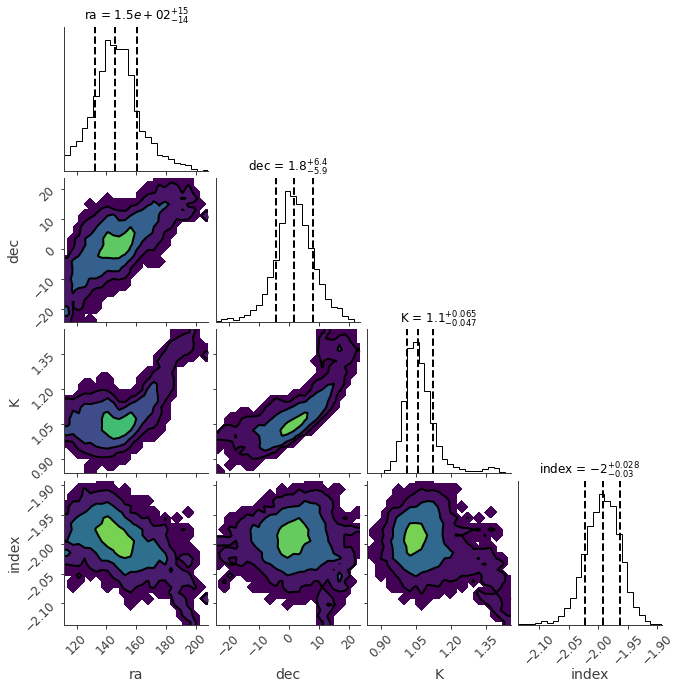

In [9]:
ba.results.corner_plot()